# Paper plots and statistics

This notebook contains the plots and statistics that made their way into the final peper or apppendix.

## Setup

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 8)  # Defuault: (6, 4)
plt.rcParams['figure.dpi'] = 300

In [3]:
source_file = "review_176995_20220923190353.csv"
source_path = os.path.join("data", source_file)
papers_df = pd.read_csv(source_path)
papers_df.drop(
    columns=["Comments (enter 'N/A' if none)", "Title.1"], inplace=True
)

## Numbers / stats

In [39]:
n_papers = papers_df.shape[0]
print(f"Total number of papers: {n_papers}")

earning_types = [
    "Supervised learning", "Unsupervised learning",
    "Reinforcement learning", "Biological / physiological model"
]
print()
print("Papers per algotithm type: ")
print(pd.DataFrame({
    "Total": papers_df[earning_types].sum(),
    "(%)": papers_df[earning_types].sum() / n_papers*100,
}))

print()
n_last_5_years = (papers_df["Year of publication"] > 2016).sum()
n_before_2010 = (papers_df["Year of publication"] < 2010).sum()
print(f"Number of papers in the last 5 yeas: {n_last_5_years} ({100 * n_last_5_years / n_papers:.1f} %)")
print(f"Number of papers before 2010: {n_before_2010} ({100 * n_before_2010 / n_papers:.1f} %)")

print()
tmp_df = papers_df[papers_df["Number of patient episodes is specified"]]
print(pd.DataFrame({
    "Overall": tmp_df["Total number of patient episodes"].dropna().apply(lambda x: float(x.replace(",", ""))).describe(percentiles=[0.1, 0.9]),
} | {
    lt: tmp_df[tmp_df[lt]]["Total number of patient episodes"].dropna().apply(lambda x: float(x.replace(",", ""))).describe(percentiles=[0.1, 0.9]) for lt in learning_types
}))

print()
n_clinical_trials = (papers_df["Randomised interventional validation (clinical trial)"]).sum()
n_patients_in_trial = papers_df[papers_df["Randomised interventional validation (clinical trial)"]]["Total number of patient episodes"].item()
print(f"There is {n_clinical_trials} clinical trial paper, inclusing {n_patients_in_trial} patients.")
                                 

Total number of papers: 73

Papers per algotithm type: 
                                  Total        (%)
Supervised learning                  55  75.342466
Unsupervised learning                 8  10.958904
Reinforcement learning               26  35.616438
Biological / physiological model      4   5.479452

Number of papers in the last 5 yeas: 61 (83.6 %)
Number of papers before 2010: 3 (4.1 %)

             Overall  Supervised learning  Unsupervised learning  \
count      71.000000            53.000000               8.000000   
mean    27051.985915         30060.094340           21375.000000   
std     56915.181407         64650.288231           31119.562405   
min        12.000000            12.000000             541.000000   
10%        95.000000            96.000000             697.800000   
50%     14908.000000         10066.000000           13986.500000   
90%     49299.000000         50158.200000           43679.100000   
max    359390.000000        359390.000000           96

## Plots

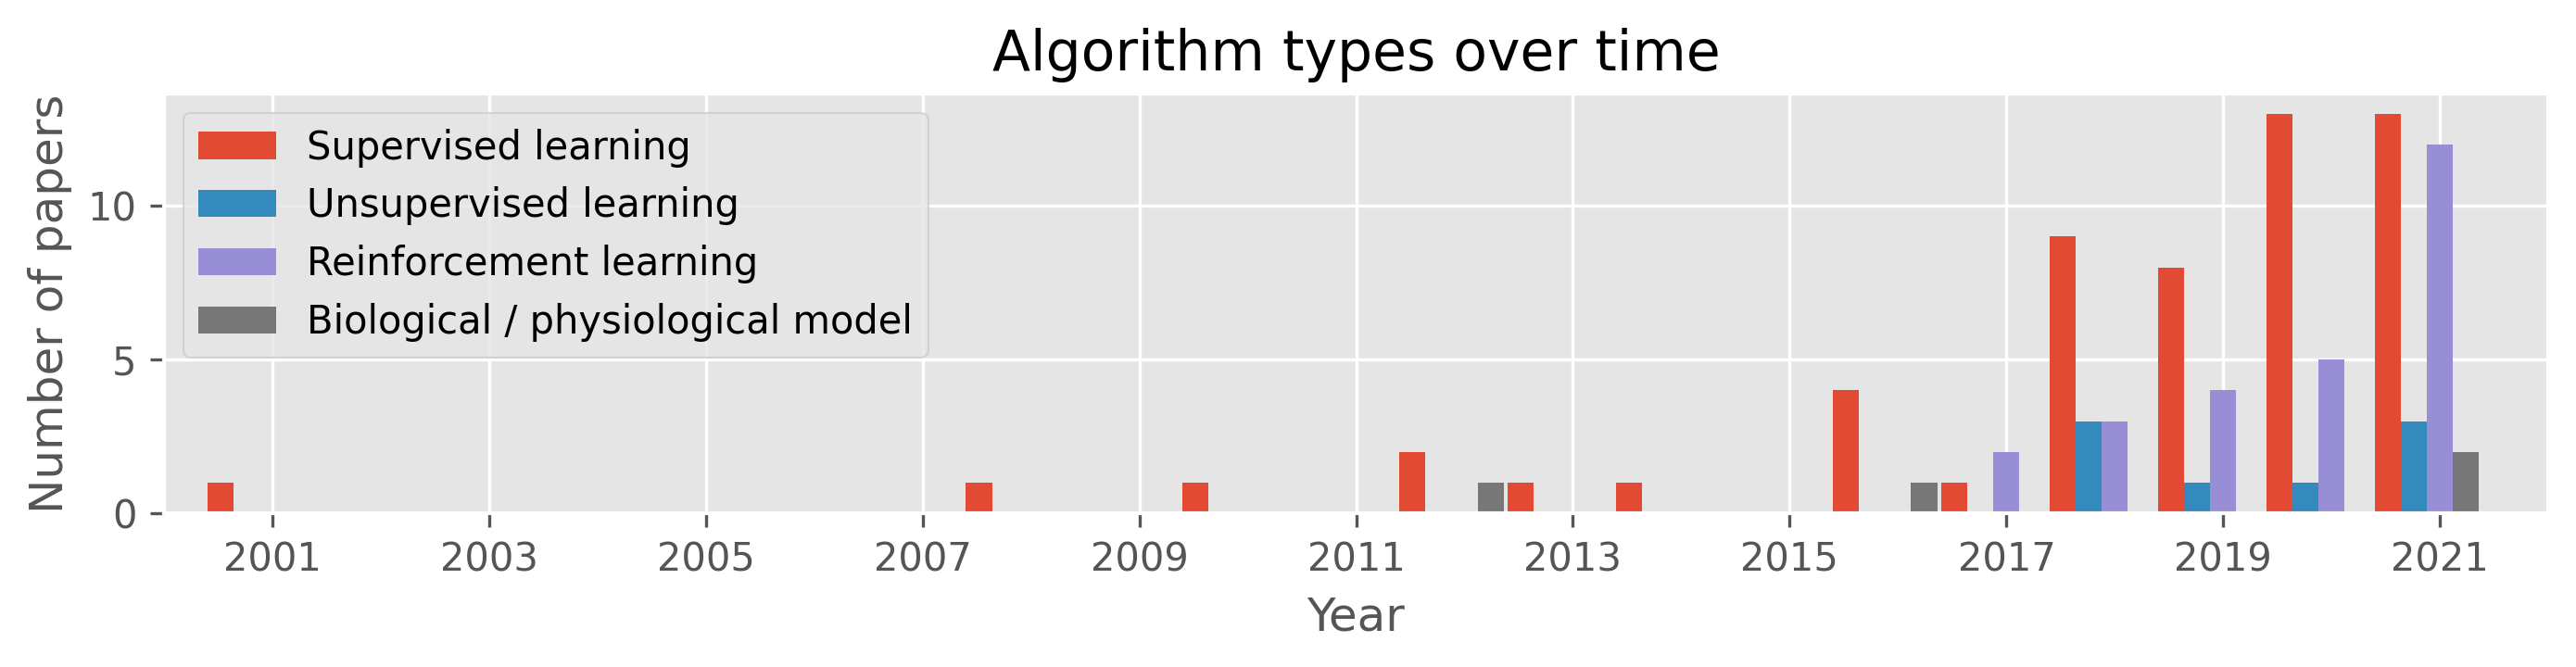

In [5]:
learning_types = [
    "Supervised learning", "Unsupervised learning",
    "Reinforcement learning", "Biological / physiological model"
]
tmp_df = papers_df.groupby("Year of publication")[learning_types].sum()

plt.rcParams["figure.figsize"] = (9.5, 2.5)  # Defuault: (6, 4)
index = np.array(sorted(list(papers_df["Year of publication"].unique())))
bar_width = 0.24
for itr, algo_type in enumerate(learning_types):
    plt.bar(index + itr*bar_width - 2*bar_width, tmp_df[algo_type], bar_width, label=algo_type)
plt.xlim(2000, 2022)
plt.xticks(np.arange(2001, 2022, 2), np.arange(2001, 2022, 2))

plt.title("Algorithm types over time")
plt.ylabel("Number of papers")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join("out", f"Algorithm - VS time.svg"))
plt.show()

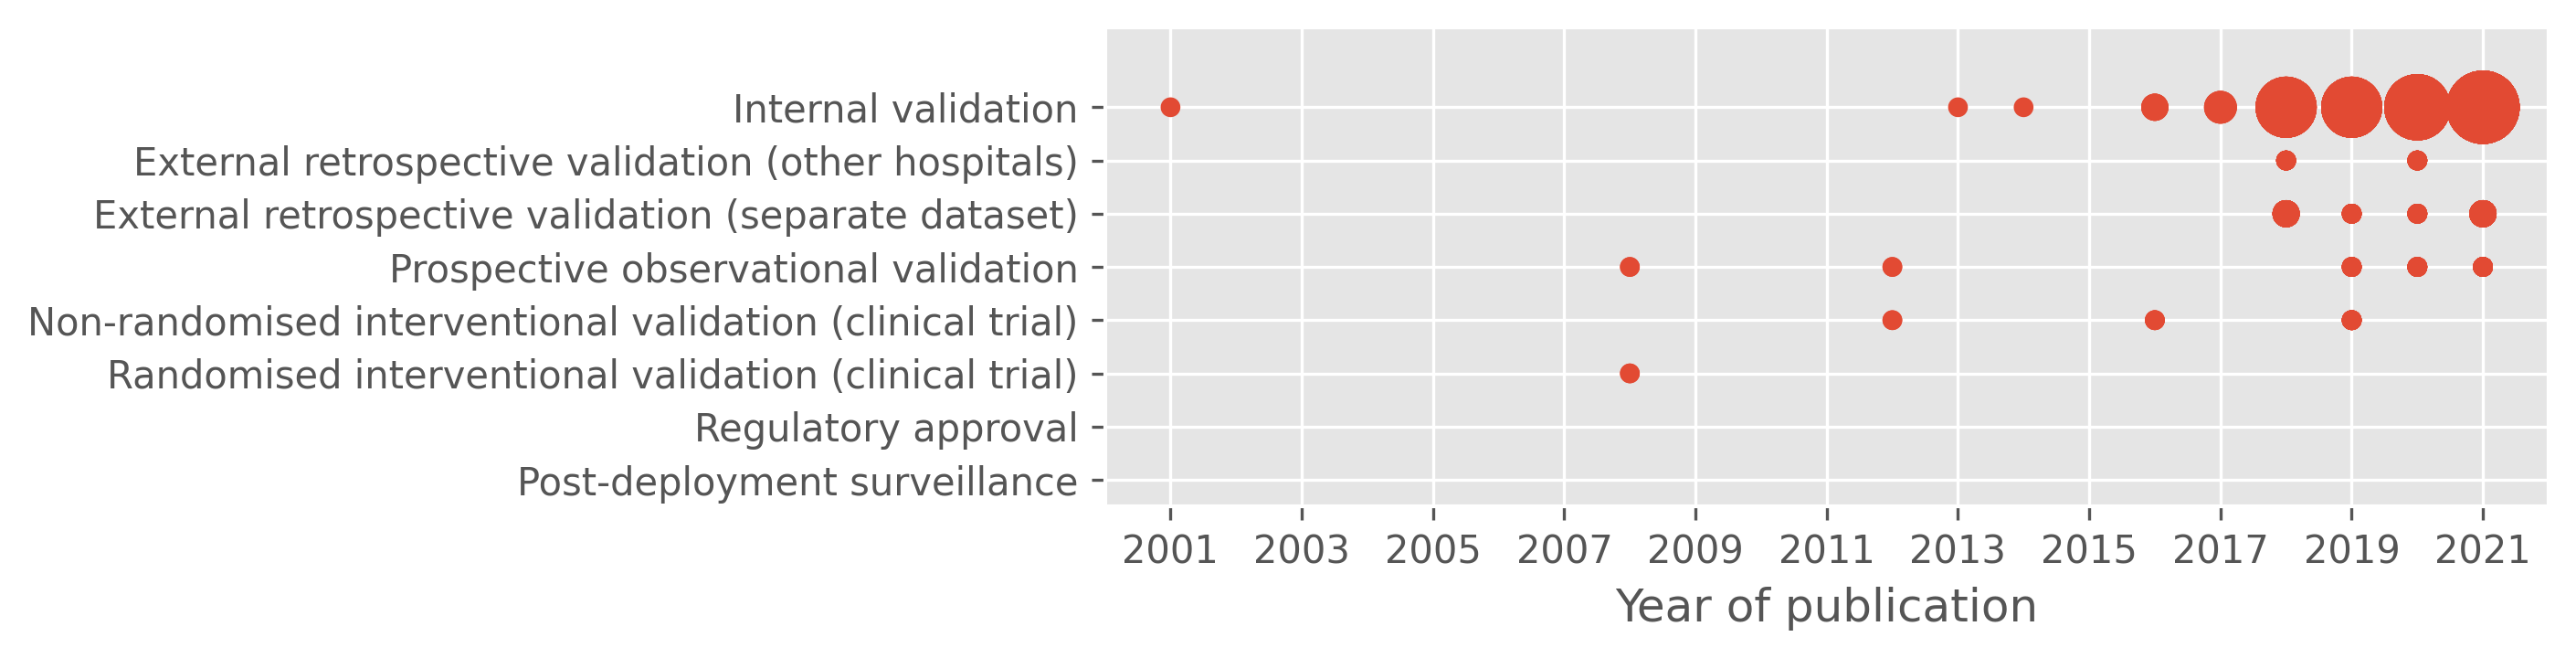

In [12]:
YEAR = "Year of publication"
VAL_TYPE = "validation"
validation_stages = [
    "Internal validation",
    "External retrospective validation (other hospitals)",
    "External retrospective validation (separate dataset)",
    "Prospective observational validation",
    "Non-randomised interventional validation (clinical trial)",
    "Randomised interventional validation (clinical trial)",
    "Regulatory approval",
    "Post-deployment surveillance"
]

tmp_df = papers_df.copy()

# Create a validation column with the name of the furthest stage of validation of each paper
tmp_df[VAL_TYPE] = [None for itr in range(len(papers_df))]
for row_idx in range(tmp_df.shape[0]):
    for val_stage in validation_stages:
        if tmp_df[val_stage][row_idx]:
            tmp_df.loc[row_idx, VAL_TYPE] = val_stage

#QOL functions
def get_papers_in_year_and_val(year, val):
    return tmp_df[(tmp_df[YEAR] == year) & (tmp_df[val])].shape[0]

def get_scatter_xyr(year, val):
    x = year - tmp_df[YEAR].min()
    y = validation_stages.index(val)
    r = tmp_df[(tmp_df[YEAR] == year) & (tmp_df[val])].shape[0]
    return x, y, r

# Data extraction
xs, ys, rs = [], [], []
for year in tmp_df[YEAR]:
    for val in validation_stages:
        x, y, r = get_scatter_xyr(year, val)
        xs.append(x)
        ys.append(y)
        rs.append(0 if r==0 else r*22)

# Plot
plt.rcParams["figure.figsize"] = (9.5, 2.5)  # Defuault: (6, 4)

plt.scatter(xs, ys, rs)
plt.xticks(list(range(0, 21, 2)), list(range(2001, 2022, 2)))
plt.yticks(list(range(len(validation_stages))), validation_stages)
plt.xlabel("Year of publication")
#plt.ylabel("Extent of validation")
plt.ylim(-1.5, 7.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join("out", f"Bubble plot.png"))
plt.savefig(os.path.join("out", f"Bubble plot.svg"))

plt.show()